# Imagini spectrale:
## Imaginile spectrale colectează și procesează informații din întregul spectru electromagnetic. Scopul imaginilor spectrale este de a obține spectrul pentru fiecare pixel dintr-o imagine, având ca obiectiv găsirea obiectelor, identificarea materialelor sau detectarea proceselor. În timp ce ochiul uman percepe culorile în principal în trei benzi (lungimi de undă lungi, percepute ca roșu; lungimi de undă medii, percepute ca verde; și lungimi de undă scurte, percepute ca albastru), imaginile spectrale împart spectrul în mult mai multe benzi.
# Domenii unde pot fi utilizate:
## - Agricultura
## - Calitatea apei
## - Militar

# Incarcarea bibliotecilor



In [1]:
import scipy.io as sio
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier

# Incarcarea setului de date si a ground truth-ului.
## Pentru un afisaj concret al elementor clasificate am folosit un map pentru a asocia pozitiile clasei cu denumirea elementului din imaginea spectrala.

In [6]:
hyperspectral_image=sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
hyperspectral_image = hyperspectral_image.astype(np.float64) / 65535.0

ground_truth=sio.loadmat('Indian_pines_gt.mat')
ground_truth=ground_truth['indian_pines_gt']

unique_classes = np.unique(ground_truth)

class_mapping = {
    0: "Background",
    1: "Alfalfa",
    2: "Corn-notill",
    3: "Corn-mintill",
    4: "Corn",
    5: "Grass-pasture",
    6: "Grass-trees",
    7: "Grass-pasture-mowed",
    8: "Hay-windrowed",
    9: "Oats",
    10: "Soybean-notill",
    11: "Soybean-mintill",
    12: "Soybean-clean",
    13: "Wheat",
    14: "Woods",
    15: "Buildings-Grass-Trees-Drives",
    16: "Stone-Steel-Towers"
}

class_names = [class_mapping.get(cls, "Unknown") for cls in unique_classes if cls in class_mapping]
print("Class Names:", class_names)
print(len(class_names))

Class Names: ['Background', 'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers']
17


## Am folosit functia reshape pentru a selecta doar cate elemente avem nevoie.In cadrul imaginii indian pines putem observa este de 145*145 pixeli si 220 de benzi spectrale

In [7]:
y=ground_truth.reshape((145*145,1))
X=hyperspectral_image.reshape((145*145,200))

## Aplicarea PCA asupra imaginii pentru a observa cata informatie este retinuta in functie de numarul de elemente

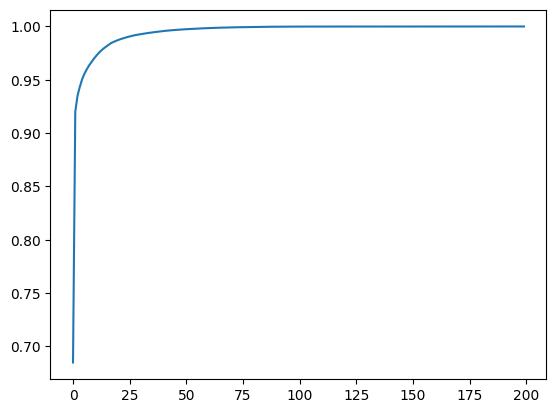

In [8]:
pca = PCA(); pcX = pca.fit_transform(X)
ev=pca.explained_variance_ratio_ ; cumulativeVar = np.cumsum(ev)
plt.plot(cumulativeVar)

## Impartirea imaginii in mai multe parti.Am utilizat o abordare diferita,am impartit setul de antrenare in 0.2,dar am parcurs toata imaginea folosind o bucla for.

In [9]:
def split_data(X, y, number_of_iterations):
    data_parts = np.array_split(np.random.permutation(range(len(X))), number_of_iterations)
    return data_parts

## Aplicarea PCA-ului asupra matricii

In [10]:
# Function to perform PCA
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    pcX_train = pca.transform(X_train)
    pcX_test = pca.transform(X_test)
    return pcX_train, pcX_test

#SVM
##Descrierea metodei:
###SVM reprezint un set de metode supervizate folosit pentru clasificare,regresie sau detectia anomaliilor.
###In cadrul metodei SVM principiul de baza reprezinta gasirea unui hiperplan optim in care sa se maximizeze marginea dintre clasele de date.
##Avantaje:
###-Bun pentru seturi de date reduse
###-Bun in spatii dimensionale mari
###-Atunci cand numarul dimensiunilor este mai mare decat numarul de caracteristici
###-Versatil:in functie de kernel se pot clasifica divese tipuri de seturi de date

##Dezavantaje:
###-Dacă numărul de caracteristici este mult mai mare decât numărul de exemple, se va evita supraînvățărea prin alegerea funcțiilor kernel și a termenului de regularizare.
###-SVM este mult mai potrivit pentru probleme de clasificare binare,rezulatate mai slabe in clasificarea multiclasa

In [11]:
def train_and_evaluate_svm(X_train, y_train, X_test, y_test, C=1.0, kernel='rbf'):
    clf =svm.SVC(C=C, kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test).reshape(-1,1)
    accuracy = accuracy_score(y_test, y_pred)
    return y_pred, accuracy

#Random Forest
##Random Forest este un algoritm de învățare automată bazat pe tehnici de ansamblu, utilizat pentru probleme de clasificare și regresie. Aceasta funcționează prin construirea unui număr mare de arbori de decizie independenți în timpul antrenării și combinarea predicțiilor acestora pentru a obține un rezultat final robust și precis.
##Avantaje:
###-Robust:se reduce riscut de overfitting datorita utilizarii mai multor arbori de decizie,functioneaza bine pe seturi de date mari
###-Versatil
###-Scalabil
###-Rezistent la zgomot
##Dezavantaje:
###-Complexitate ridicata datorita faptului ca este bazat pe arbori de decizie
###-Sensibil la hiperparametri


In [12]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, n_estimators=100):
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test).reshape(-1,1)
    accuracy = accuracy_score(y_test, y_pred)
    return y_pred, accuracy

##Functia de plot unde atasez ground truth-ul langa imaginea clasificata.I am dat reshape la size ul initial pentru a le putea compara.

In [13]:
def plot_results(y_pred_list, y, shape, class_names):
    y_pred_img = y_pred_list.reshape(shape)
    y_img = y.reshape(shape)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(y_pred_img, cmap='jet')
    plt.title('Predicted')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(y_img, cmap='jet')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Matricea de confuzie afisata printr-un heatmap

In [14]:
def plot_confusion_matrix(y_test, y_pred, class_names):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## Aplicarea SVM-ului asupra setului de date.
##Avand in vedere ca este vorba despre o imagine hyperspectrala am ales parametrul de regularizare astfel incat sa mi clasifice cat mai multe caracteristici ale imaginii

In [15]:
def svm_with_pca(X, y, n_components=100, number_of_iterations=5, C=100, kernel='rbf', class_names=None, shape=(145, 145)):
    accuracy_list = []
    y_pred_list = np.zeros_like(y)

    data_parts = split_data(X, y, number_of_iterations)

    for i in range(number_of_iterations):
        test_indices = data_parts[i]
        train_indices = np.concatenate([data_parts[j] for j in range(number_of_iterations) if j != i])

        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        pcX_train, pcX_test = apply_pca(X_train, X_test, n_components)

        y_pred, accuracy = train_and_evaluate_svm(pcX_train, y_train, pcX_test, y_test, C, kernel)

        y_pred_list[test_indices] = y_pred
        accuracy_list.append(accuracy)

    avg_accuracy = np.mean(accuracy_list)
    print("Average accuracy:", avg_accuracy)

    plot_results(y_pred_list, y, shape, class_names)

    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_confusion_matrix(y_test, y_pred, class_names)

## Aplicarea metodei Random Forest

In [16]:
def random_forest_with_pca(X, y, n_components=100, number_of_iterations=5, n_estimators=100, class_names=None, shape=(145, 145)):
    accuracy_list = []
    y_pred_list = np.zeros_like(y)

    data_parts = split_data(X, y, number_of_iterations)

    for i in range(number_of_iterations):
        test_indices = data_parts[i]
        train_indices = np.concatenate([data_parts[j] for j in range(number_of_iterations) if j != i])

        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        pcX_train, pcX_test = apply_pca(X_train, X_test, n_components)

        y_pred, accuracy = train_and_evaluate_rf(pcX_train, y_train, pcX_test, y_test, n_estimators)

        y_pred_list[test_indices] = y_pred
        accuracy_list.append(accuracy)

    avg_accuracy = np.mean(accuracy_list)
    print("Average accuracy:", avg_accuracy)

    plot_results(y_pred_list, y, shape, class_names)

    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_confusion_matrix(y_test, y_pred, class_names)

##Apelarea in functia main a celor doua functii

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Average accuracy: 0.837717003567182


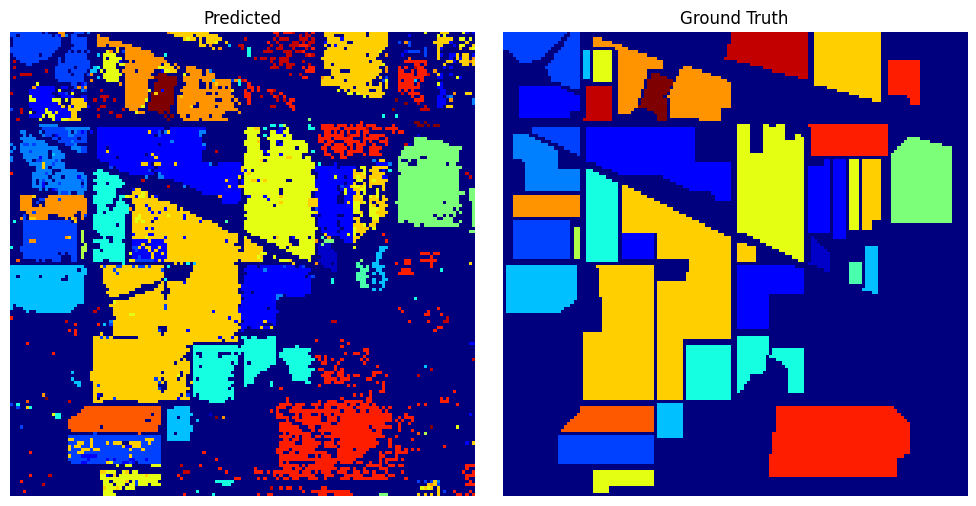

                              precision    recall  f1-score   support

                  Background       0.85      0.88      0.86      2213
                     Alfalfa       0.70      0.88      0.78         8
                 Corn-notill       0.84      0.83      0.84       298
                Corn-mintill       0.81      0.78      0.80       166
                        Corn       0.71      0.80      0.75        45
               Grass-pasture       0.91      0.83      0.87       100
                 Grass-trees       0.87      0.83      0.85       132
         Grass-pasture-mowed       1.00      0.44      0.62         9
               Hay-windrowed       0.91      0.90      0.91       103
                        Oats       0.75      0.75      0.75         4
              Soybean-notill       0.81      0.79      0.80       165
             Soybean-mintill       0.79      0.85      0.82       450
               Soybean-clean       0.90      0.79      0.84       121
                   

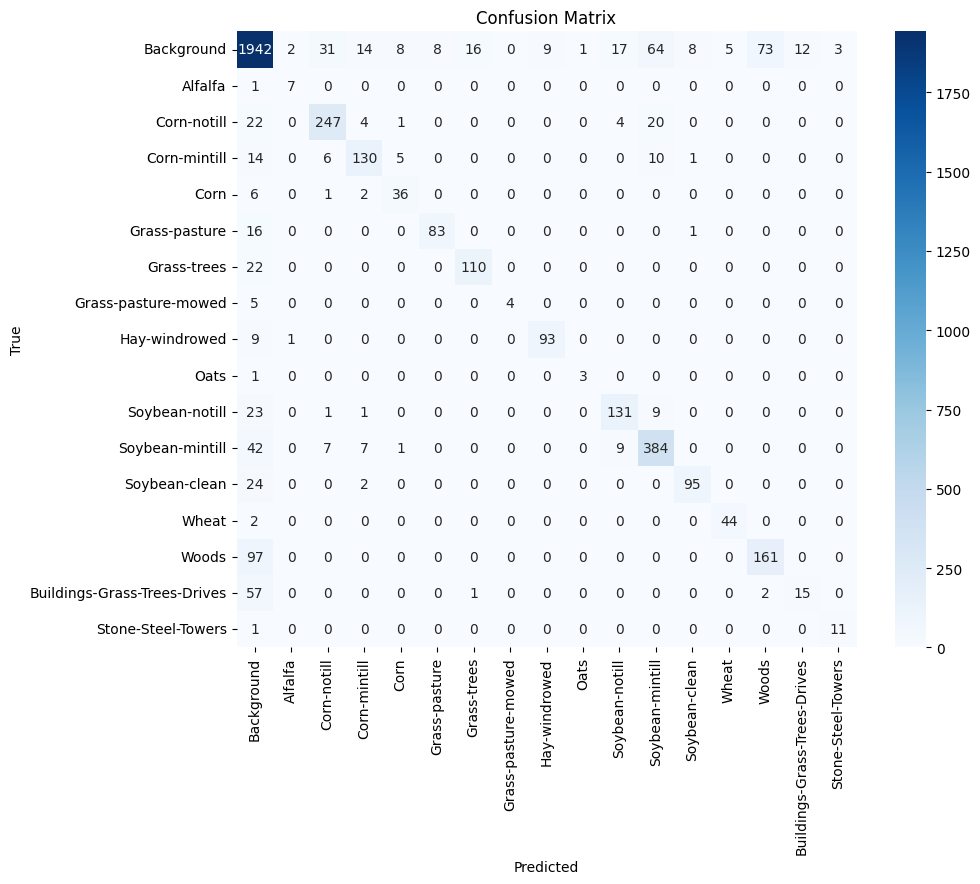

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Average accuracy: 0.7657074910820453


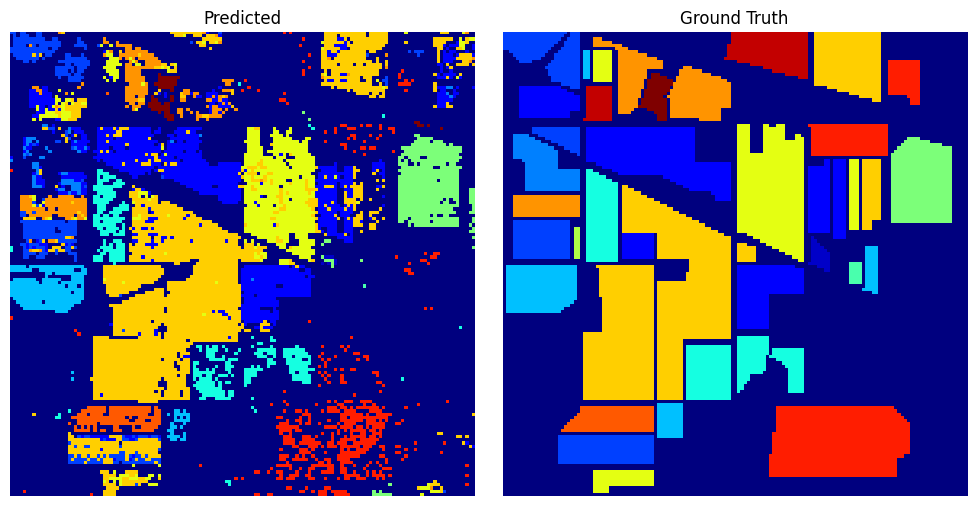

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                              precision    recall  f1-score   support

                  Background       0.75      0.92      0.83      2134
                     Alfalfa       1.00      0.23      0.38        13
                 Corn-notill       0.76      0.70      0.73       302
                Corn-mintill       0.91      0.56      0.69       180
                        Corn       0.64      0.18      0.29        49
               Grass-pasture       0.98      0.55      0.70        84
                 Grass-trees       0.93      0.58      0.72       149
         Grass-pasture-mowed       0.00      0.00      0.00         6
               Hay-windrowed       0.81      0.88      0.84        90
                        Oats       0.00      0.00      0.00         3
              Soybean-notill       0.79      0.65      0.71       192
             Soybean-mintill       0.73      0.85      0.78       473
               Soybean-clean       0.84      0.47      0.60       115
                   

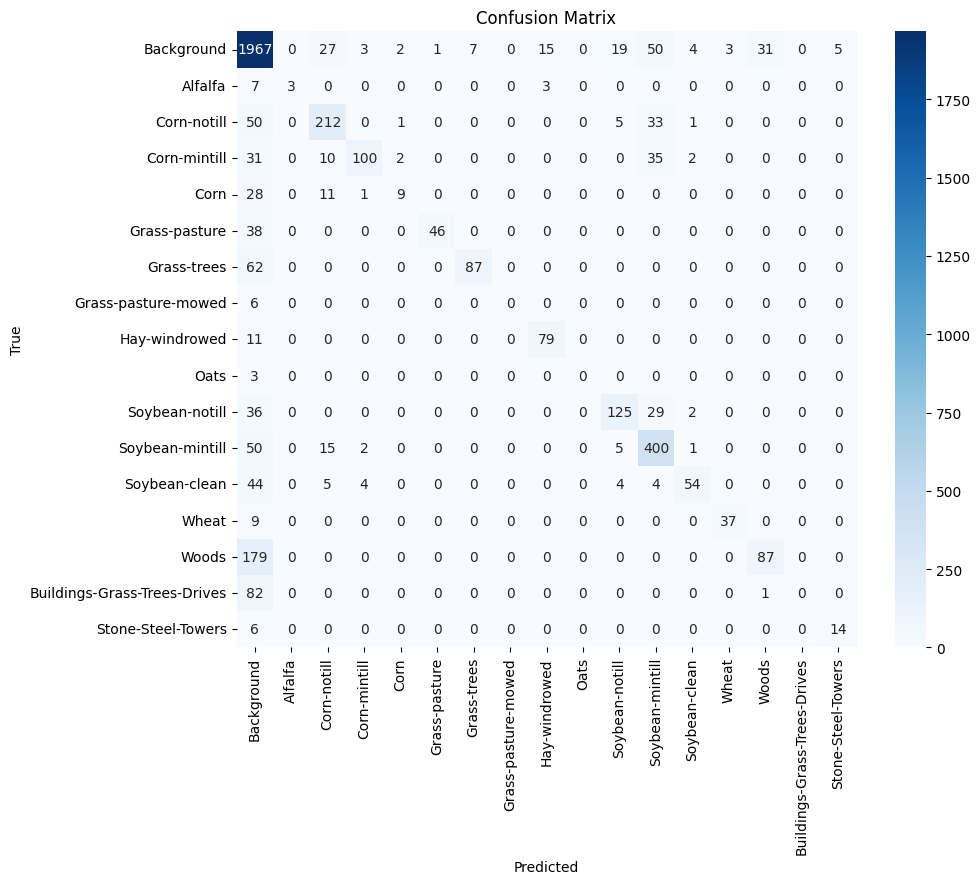

In [26]:
if __name__ == "__main__":
    svm_with_pca(X,y,100,5,100,'rbf',class_names,(145,145))
    random_forest_with_pca(X,y,100,5,200,class_names,(145,145))

#Concluzii:
##Care dintre cele doua metode s-a descurcat mai bine?
###SVM s a descurcat mai bine datorita capacitatii de a gasi limite optime in spatii de dimensiuni mari si datorita capacitatii de a modela relatii neliniare.RF,desti este robust,pierde din precizie datorita dificultatii de a separa clasele intr-un spatiu de caracteristici mare.
##Cum au influentat caracteristicile imaginilor hiperspectrale performanta fiecarei metodei?
##SVM
###Benzile hiperspectrale conțin informații fine despre materialele de pe teren, iar SVM a fost capabil să modeleze aceste relații non-liniare, ceea ce a dus la o performanță superioară.
###SVM este eficient în separarea claselor care au caracteristici spectrale distincte, esențial în imagini hiperspectrale, unde materialele pot fi diferențiate pe baza răspunsurilor spectrale specifice.
##RF
###Chiar dacă PCA a redus redundanța, RF a fost mai puțin eficient în captarea relațiilor spectrale subtile între benzi, deoarece selecția aleatorie a caracteristicilor pierde informații importante.
###Imaginile hiperspectrale conțin zgomot în unele benzi, ceea ce poate afecta performanța RF mai mult decât pe cea a SVM, deoarece RF nu are mecanisme directe pentru a atenua zgomotul în procesul de decizie.